# Homework 07
This weeks task is to implement a LSTM (Long short-term memory) network. To test our implementation we will predict if the integral of some given noise sequence is positive of negative.


In [1]:
import tensorflow as tf

from data_preparation import Data_Preparation
from lstm import LSTM_Model, LSTM_Layer
from training import training
import visualize

## 1. Generate Dataset

In [2]:
SEQUENCE_LENGTH = 30
DATASET_LENGTH = 80_000
BATCH_SIZE = 150

# intialize Data_Preparator object
data_preparator = Data_Preparation(SEQUENCE_LENGTH, DATASET_LENGTH)
# generate datasets, split into train, test and validation and preprocess
datasets = data_preparator.generate_data(BATCH_SIZE)


## 2. Model
#### Questions: 

**1. Can / should you use truncated BPTT here?**\
BPTT or Backpropagation Through Time is basically backpropagation applied to the whole time sequence at once. It can be computationally heavy and lead to vanishing or exploding gradients if we have large time sequences. Truncated BPTT partially solves this problem by basically batching the time sequence and applying backpropagation to each batched time sequence. This leads to a periodic update to the weights instead of all at once. In general truncated BPTT is a great idea for recurrent neural networks, but since our time sequence is still rather short with 25 elements we do not think it to be necessary. Our sequence length is comparable to the size of one batch for bigger time sequences.

**2. Should you rather take this as a regression, or a classification problem?**\
To answer, if we should rather take this as a regression, or a classification problem one has to take a look at the differences in the between classification and regression. Generally classification is about predicting the correct discrete label while regression is about predicting a continuous output. The main difference is that classification predictions can be evaluated using accuracy, whereas regression predictions can be evaluated using mean squared error. Since we coded the sum of the time sequence either as labels 0 or 1 corresponding to below 1 and above 1, one could assume that this can only be a classification Problem. This is wrong. In this case it can also be solved using an regression predictive model since regression algorithm can predict a discrete value of integer quantity as in our case 0 or 1. But since we do not want to predict a quantity like the sum, but only if it is above or below one, a classification predictive model should be the likely way to go.

In [3]:
model = LSTM_Model(layer_list=[
    tf.keras.layers.Dense(50, activation='sigmoid'),
    LSTM_Layer(units=6),
    tf.keras.layers.Dense(3, activation='sigmoid'),
    tf.keras.layers.Dense(1, activation='sigmoid')]
)
model.build(input_shape=(None, 20, 1))
model.summary()

Model: "lstm__model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  100       
                                                                 
 lstm__layer (LSTM_Layer)    multiple                  1368      
                                                                 
 dense_5 (Dense)             multiple                  21        
                                                                 
 dense_6 (Dense)             multiple                  4         
                                                                 
Total params: 1,493
Trainable params: 1,493
Non-trainable params: 0
_________________________________________________________________


## 3. Training and Analysis

In [4]:
# Initialize the loss-function
loss_func = tf.keras.losses.BinaryCrossentropy()
# Initialize the optimizer
optimizer = tf.keras.optimizers.Adam(0.001)
# Train our LSTM-Model using datasets, loss_func and the optimizer
losses, accuracies = training(model, datasets, loss_func, optimizer, epochs=10)

Epoch 1 starting with valid. accuracy: 0.507 and loss: 0.7099999785423279
Epoch 2 starting with valid. accuracy: 0.91 and loss: 0.46799999475479126
Epoch 3 starting with valid. accuracy: 0.932 and loss: 0.28700000047683716
Epoch 4 starting with valid. accuracy: 0.954 and loss: 0.19699999690055847
Epoch 5 starting with valid. accuracy: 0.949 and loss: 0.17000000178813934
Epoch 6 starting with valid. accuracy: 0.94 and loss: 0.17000000178813934
Epoch 7 starting with valid. accuracy: 0.986 and loss: 0.08699999749660492
Epoch 8 starting with valid. accuracy: 0.983 and loss: 0.07800000160932541
Epoch 9 starting with valid. accuracy: 0.974 and loss: 0.08100000023841858
Epoch 10 starting with valid. accuracy: 0.916 and loss: 0.21799999475479126


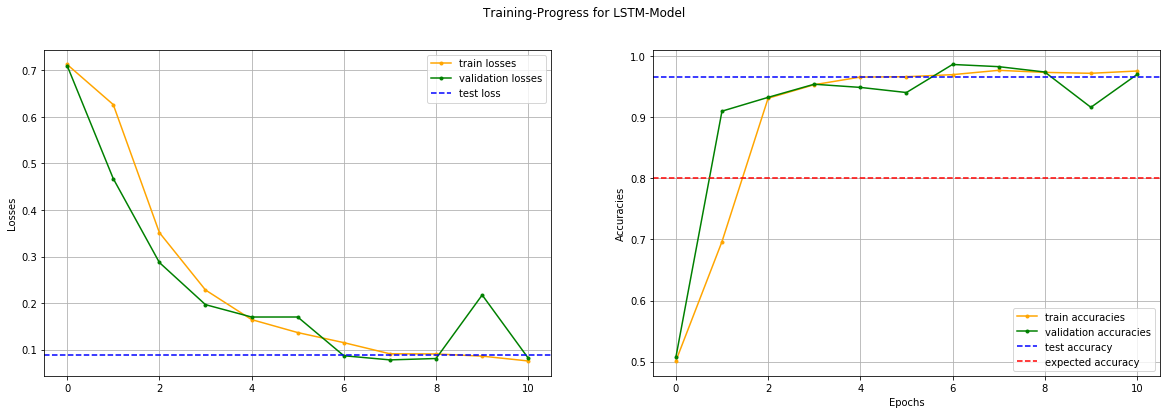

In [5]:
visualize.plot_results(losses, accuracies, 'Training-Progress for LSTM-Model')